In [157]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import GridSearch
import pandas as pd
from surprise import Reader
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from multiprocessing import Pool
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt

In [2]:
train_file = "../datasets/ua.base"
test_file = "../datasets/ua.test"

In [3]:
col_names = [ "user", "movie", "rating", "timestamp" ]

In [4]:
train = pd.read_csv(train_file, sep="\t", header=None, names=col_names)

In [5]:
test = pd.read_csv(test_file, sep="\t", header=None, names=col_names)

In [6]:
train[0:5]

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [8]:
train_dataset = Dataset.load_from_df(train[["user", "movie", "rating"]], reader).build_full_trainset()

In [9]:
svdpp = SVDpp()

In [10]:
svdpp.fit(train_dataset)

In [26]:
test["predictions"] = test.apply(lambda row: svdpp.predict(row[0], row[1]), axis=1)    

In [47]:
test["predictions_prop"] = test.apply( lambda row: row[4].est / 5 , axis=1 )

In [48]:
test[0:5]

,user,movie,rating,timestamp,predictions,predictions_prop
0,1,20,4,887431883,"(1.0, 20.0, None, 3.6111639336156043, {'was_im...",0.722233
1,1,33,4,878542699,"(1.0, 33.0, None, 3.29084608025631, {'was_impo...",0.658169
2,1,61,4,878542420,"(1.0, 61.0, None, 4.016318579265638, {'was_imp...",0.803264
3,1,117,3,874965739,"(1.0, 117.0, None, 4.012934507825617, {'was_im...",0.802587
4,1,155,2,878542201,"(1.0, 155.0, None, 1.988308066493604, {'was_im...",0.397662


In [61]:
test["y_true"] = test.apply( lambda row: round(row[2] / 5), axis=1)

In [62]:
test["y_score"] = test["predictions_prop"].apply(lambda i: round(i) )

In [59]:
test[0:5]

,user,movie,rating,timestamp,predictions,predictions_prop,predictions_x,predictions_y
0,1,20,4,887431883,"(1.0, 20.0, None, 3.6111639336156043, {'was_im...",0.722233,1,1
1,1,33,4,878542699,"(1.0, 33.0, None, 3.29084608025631, {'was_impo...",0.658169,1,1
2,1,61,4,878542420,"(1.0, 61.0, None, 4.016318579265638, {'was_imp...",0.803264,1,1
3,1,117,3,874965739,"(1.0, 117.0, None, 4.012934507825617, {'was_im...",0.802587,1,1
4,1,155,2,878542201,"(1.0, 155.0, None, 1.988308066493604, {'was_im...",0.397662,0,0


In [63]:
precision_score(test["y_true"], test["y_score"])

0.8634888665100146

In [64]:
recall_score(test["y_true"], test["y_score"])

0.9777017610540986

In [65]:
roc_auc_score(test["y_true"], test["y_score"])

0.5919738473455268

# Compute hyperparameter matrix

In [80]:
n_factors = [ 10, 20 ]
n_epochs = [ 20 , 30 ]
lr_all = [ 0.001, 0.01, 0.1 ]

In [82]:
svpp_array = [ { "n_factors": n, "n_epochs": e, "lr_all": l } for n in n_factors for e in n_epochs for l in lr_all ]

In [95]:
def fit_model(opts):
    return (opts, SVDpp(n_factors=opts["n_factors"], n_epochs=opts["n_epochs"], lr_all=opts["lr_all"]).fit(train_dataset))

In [96]:
with Pool(6) as p:
    svpp_models = p.map( fit_model, svpp_array )

In [97]:
svpp_models

[({'lr_all': 0.001, 'n_epochs': 20, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647d5240b8>),
 ({'lr_all': 0.01, 'n_epochs': 20, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647d522e48>),
 ({'lr_all': 0.1, 'n_epochs': 20, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647e62a320>),
 ({'lr_all': 0.001, 'n_epochs': 30, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f648750a0f0>),
 ({'lr_all': 0.01, 'n_epochs': 30, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647d522ef0>),
 ({'lr_all': 0.1, 'n_epochs': 30, 'n_factors': 10},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647e0f65f8>),
 ({'lr_all': 0.001, 'n_epochs': 20, 'n_factors': 20},
  <surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f647d522da0>),
 ({'lr_all': 0.01, 'n_epochs': 20, 'n_factors': 20},
 

In [103]:
svpp_models_byte = pickle.dumps(svpp_models)

In [104]:
joblib.dump(svpp_models_byte, 'svpp_models_hyp.pkl')

['svpp_models_hyp.pkl']

In [151]:
def compute_scores(model, test):
    test_copy = test.copy(deep=True)
    test_copy["predictions"] = test_copy[["user", "movie"]].apply(lambda r: model.predict(r[0], r[1]), axis=1)   
    test_copy["predictions_prop"] = test_copy["predictions"].apply( lambda p: p.est / 5 )
    test_copy["y_true"] = test_copy["rating"].apply( lambda r: round(r / 5))
    test_copy["y_score"] = test_copy["predictions_prop"].apply(lambda p: round(p) )
    return {
        "precision": precision_score(test_copy["y_true"], test_copy["y_score"]),
        "recall": recall_score(test_copy["y_true"], test_copy["y_score"]),
        "auc": roc_auc_score(test_copy["y_true"], test_copy["y_score"])
    }

In [152]:
test2 = test[["user", "movie", "rating"]]

In [154]:
scores = list(map(lambda x: compute_scores(x[1], test2), svpp_models))

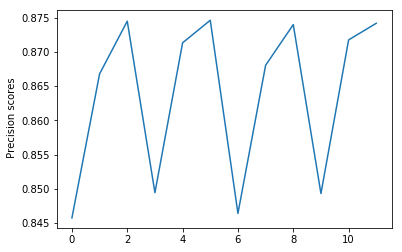

In [164]:
plt.plot( [ s["precision"] for s in scores ])
plt.ylabel(" Precision scores" )
plt.show()

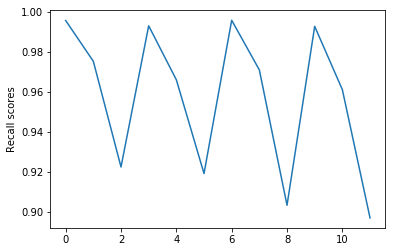

In [165]:
plt.plot( [ s["recall"] for s in scores ])
plt.ylabel("Recall scores")
plt.show()

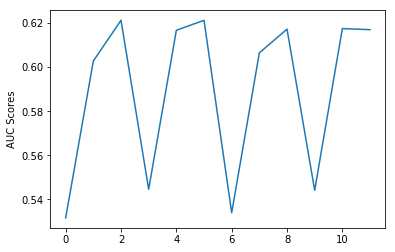

In [166]:
plt.plot( [ s["auc"] for s in scores ])
plt.ylabel("AUC Scores")
plt.show()